#### **Data Processing**

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
all_results_healthcare_clean = pd.read_csv('healthcare_with_combi_1.csv').set_index('date').drop(columns='Unnamed: 0')
all_results_tech_clean = pd.read_csv('tech_with_combi_1.csv').set_index('date').drop(columns='Unnamed: 0')
all_results_tech_clean

,rolling_alpha_5f,lasso,ridge,xgboost,lgbm,rf,pca,lstm,benchmark_alpha,simple_avg,err_weighted
date,,,,,,,,,,,
2019-03-29,-0.064261,0.011322,0.005189,0.016915,0.013942,0.012832,0.012908,0.013421,0.000000,0.012361,0.012361
2019-03-29,-0.029964,0.014797,0.008808,0.018278,0.013942,0.014267,0.017173,0.017850,0.000000,0.015017,0.014570
2019-03-29,-0.021149,-0.001822,-0.007796,-0.009167,-0.002699,-0.011748,-0.001378,-0.000003,0.000000,-0.004945,-0.007474
2019-03-29,-0.019178,-0.001233,-0.009139,-0.008551,-0.002699,-0.009513,-0.000625,0.001698,0.000000,-0.004295,-0.006738
2019-03-29,-0.017032,-0.000352,-0.003391,-0.008318,-0.002699,-0.006186,-0.000841,-0.002480,0.000000,-0.003467,-0.004750
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-28,0.045010,0.012207,0.014545,0.020629,0.014624,0.025652,0.014393,0.017015,0.002931,0.017009,0.018710
2024-07-31,0.010018,0.002183,-0.002810,0.005508,0.005679,0.006577,0.003015,-0.001950,0.004697,0.002600,0.005003
2024-07-31,0.010697,0.002353,-0.002306,0.005810,0.005706,0.006999,0.003034,0.001361,0.004697,0.003280,0.005212


In [72]:
# Generation of Error Metrics
def mean_absolute_scaled_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae = mean_absolute_error(y_true, y_pred)
    mase = mae / naive_mae if naive_mae != 0 else np.nan

    return mase 

def metrics_generator(df, metric, outcome_var, relevant_cols):
    if metric == 'MASE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_scaled_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    elif metric == 'MAE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    elif metric == 'R2':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: max(r2_score(group[outcome_var], group[col]), -2) for col in relevant_cols
            })
        )
    elif metric == 'MSE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_squared_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    else:
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: np.sqrt(mean_squared_error(group[outcome_var], group[col])) for col in relevant_cols
            })
        )
    return final_df


all_metrics_results = {metric: {} for metric in ["MASE", "MAE", "R2", "MSE", "RMSE"]}

models = ['ridge', 'rf', 'xgboost', 'pca', 'lgbm', 'lstm', 'benchmark_alpha','simple_avg','err_weighted']
# models = ['ridge', 'rf', 'pca', 'lstm']
    
rmse_healthcare = metrics_generator(all_results_healthcare_clean, metric = "RMSE", outcome_var="rolling_alpha_5f", relevant_cols = models)
rmse_tech = metrics_generator(all_results_tech_clean, metric = "RMSE", outcome_var="rolling_alpha_5f", relevant_cols = models)
# rmse_healthcare

#### **Plots**

Plot 1: Metrics Plot by Time

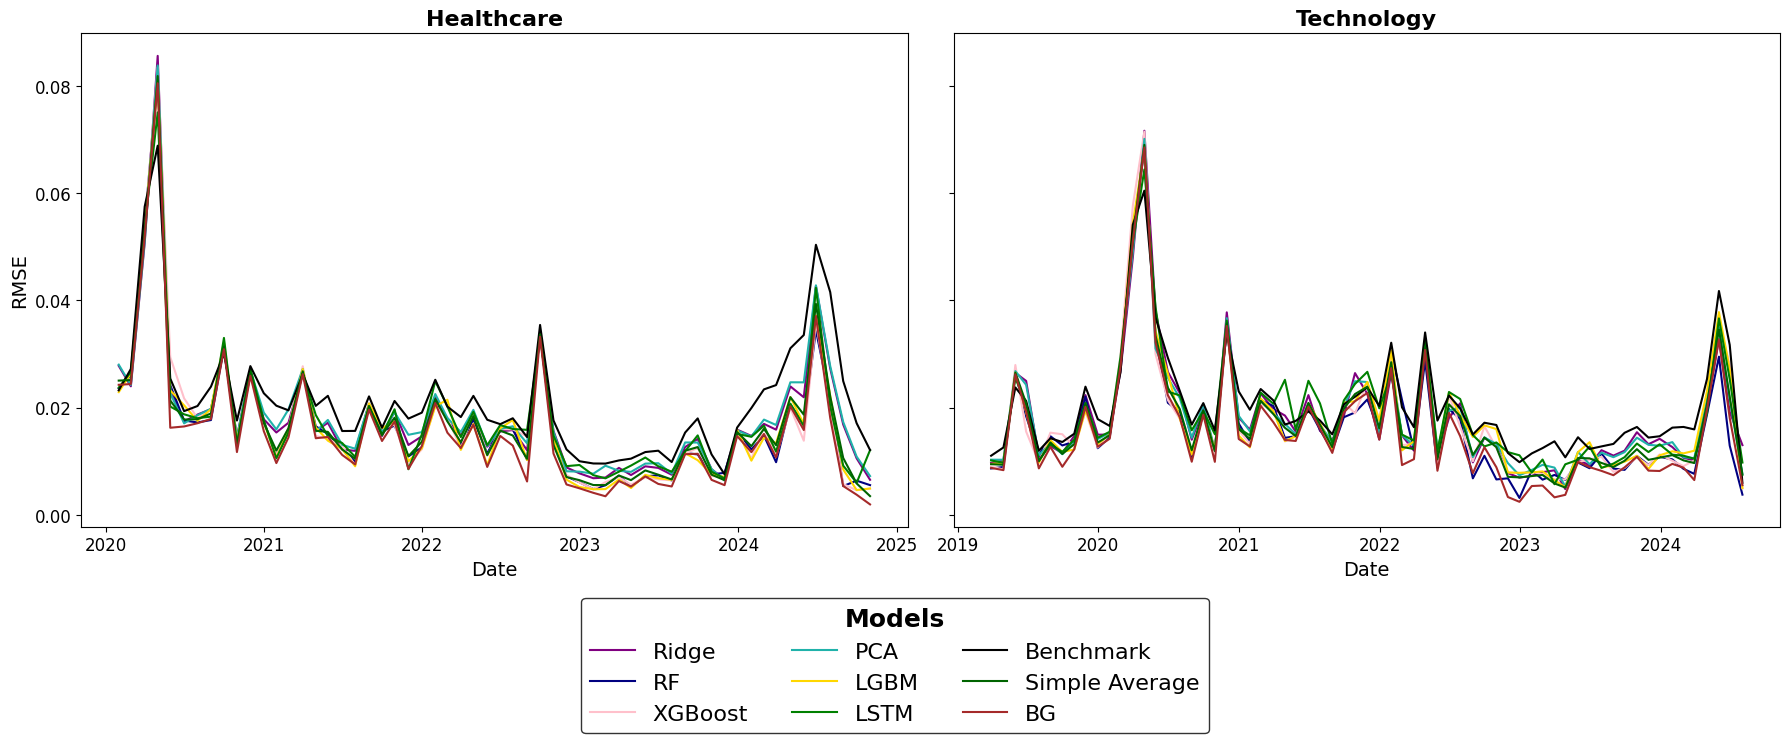

In [73]:
# Single Plot
import pandas as pd
import matplotlib.pyplot as plt
label_mapping = {'ridge': 'Ridge', 'xgboost': 'XGBoost', 'rf': 'RF', 'pca': 'PCA', 'lasso': 'Lasso',
                 'lgbm':'LGBM', 'lstm':'LSTM','benchmark_alpha':'Benchmark',
                 'simple_avg':'Simple Average', 'err_weighted':'BG'}
color_list = {'Ridge': 'purple', 'XGBoost': 'pink', 'PCA': 'lightseagreen', 'RF': 'navy', 'Lasso':'crimson', 
              'LGBM':'gold', 'LSTM':'green', 'Benchmark':'black',
              'Simple Average':'darkgreen', 'BG':'brown'}

# Load your data (assuming it's already in a DataFrame named df)
rmse_healthcare.index = pd.to_datetime(rmse_healthcare.index)  # Ensure index is datetime
rmse_tech.index = pd.to_datetime(rmse_tech.index)  # Ensure index is datetime

# Create a 1x2 subplot layout
fig, axes = plt.subplots(1, 2, figsize=(18, 6),sharey=True)

# First plot (Healthcare RMSE)
for column in rmse_healthcare.columns:
    axes[0].plot(rmse_healthcare.index, rmse_healthcare[column], label=label_mapping[column], color=color_list[label_mapping[column]])

# Formatting for the first plot
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("RMSE", fontsize=14)
axes[0].set_title("Healthcare", fontweight='bold',fontsize = 16)
# axes[0].legend()
axes[0].grid(False)
axes[0].tick_params(axis='both', labelsize=12)

# Second plot (Tech RMSE)
for column in rmse_tech.columns:
    axes[1].plot(rmse_tech.index, rmse_tech[column], label=label_mapping[column], color=color_list[label_mapping[column]])

# Formatting for the second plot
axes[1].set_xlabel("Date", fontsize=14)
# axes[1].set_ylabel("Value")
axes[1].set_title("Technology", fontweight='bold',fontsize = 16)
handles, labels = plt.gca().get_legend_handles_labels()
unique_legend = dict(zip(labels, handles))  # Remove duplicates by using a dictionary

# Add the unique legend to the figure
legend = fig.legend(unique_legend.values(), unique_legend.keys(),  
           bbox_to_anchor=(0.5, -0.25), loc='lower center', ncol=3, title = "Models",
           fontsize = 16, title_fontsize = 18)
legend.get_title().set_fontweight('bold')
legend.set_visible(True)
legend.get_frame().set_edgecolor('black')
axes[1].grid(False)
axes[1].tick_params(axis='both', labelsize=12)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Plot 3: Cumulative Alpha Over Time

In [74]:
def plot_difference(df, outcome_var):
    
    # fig, axis = plt.subplots(figsize=(12, 6))
    # legend_handles = {}
    df_to_plot = df.copy()
    df_to_plot.index = pd.to_datetime(df_to_plot.index)
    df_to_plot = df_to_plot.sort_index()
    df_to_plot = df_to_plot.groupby(df_to_plot.index).mean()  # Take mean for duplicated dates

    model_cols = [col for col in df_to_plot.columns if col != outcome_var]
    df_to_plot[outcome_var] = (df_to_plot[outcome_var] - df_to_plot[outcome_var].mean()) / df_to_plot[outcome_var].std()
    # return(df_to_plot)
    # Cumulative actual alpha
    df_to_plot["benchmark_alpha"] = (df_to_plot["benchmark_alpha"] - df_to_plot["benchmark_alpha"].mean()) / df_to_plot["benchmark_alpha"].std()
    df_to_plot['cumulative_action_based_benchmark_alpha'] = (df_to_plot["benchmark_alpha"] * df_to_plot[outcome_var]).cumsum()

    # Compute cumulative action-based alpha for all models and create diff columns
    for col in model_cols:
        if col == 'benchmark_alpha':
            df_to_plot[f'cumulative_action_based_{col}_diff'] = 0
        else:
            df_to_plot[col] = (df_to_plot[col] - df_to_plot[col].mean()) / df_to_plot[col].std()
            df_to_plot[f'cumulative_action_based_{col}'] = ((df_to_plot[col] * df_to_plot[outcome_var]).cumsum())
            df_to_plot[f'cumulative_action_based_{col}_diff'] = df_to_plot[f'cumulative_action_based_{col}'] - df_to_plot['cumulative_action_based_benchmark_alpha']

    # Now we rank the models based on the _diff (higher _diff = higher rank)
    rank_df = df_to_plot[[f'cumulative_action_based_{col}_diff' for col in model_cols]]

    # Rank based on the _diff, higher values get higher ranks
    ranked_df = rank_df.apply(lambda row: row.rank(ascending=False), axis=1)  # Rank within each date row
    # return(ranked_df)
    # Rename the columns to reflect the model names
    ranked_df.columns = model_cols  # map labels like 'ridge' to 'Ridge'
    ranked_df.index = pd.to_datetime(ranked_df.index)
    # return(ranked_df)
    
    # Combine both DataFrames (first and last month data)
    selected_months_df = ranked_df[ranked_df.index.month.isin([1, 7])]

    # Add the last month of each year
    list_of_dates = df_to_plot.index
    dates = pd.to_datetime(list_of_dates)
    df = pd.DataFrame(dates, columns=['date'])
    df['year'] = df['date'].apply(lambda x: x.year)
    max_dates = df.groupby('year')['date'].transform('max')
    final_date = pd.Series(max_dates).sort_values().unique()[-1]
    last_month = ranked_df[ranked_df.index == final_date]

    # Combine the two selections
    combined_df = pd.concat([selected_months_df,last_month])
    return(combined_df)

# Plotting Healthcare and Tech separately

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined(df, plot_difference_fn, outcome_var, color_list_sector):
    label_mapping = {'ridge': 'Ridge', 'xgboost': 'XGBoost', 'rf': 'RF', 'pca': 'PCA', 'lasso': 'Lasso', 
                     'lgbm':'LGBM', 'lstm':'LSTM','benchmark_alpha':'Benchmark',
                     'simple_avg':'Simple Average', 'err_weighted':'BG'}
    color_list = {'Ridge': 'purple', 'XGBoost': 'hotpink', 'PCA': 'lightseagreen', 'RF': 'navy', 'Lasso':'crimson', 
                  'LGBM':'gold', 'LSTM':'green', 'Benchmark':'black',
                  'Simple Average':'darkgreen', 'BG':'brown'}
    ranking_df = plot_difference_fn(df,outcome_var=outcome_var)
    # Create a 2x1 layout for the subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12), sharex = True)
    axis1, axis2 = axes[0], axes[1]
    custom_legend_handles = []
    
    # --- First plot: Cumulative Alpha ---
    df_to_plot = df.copy()
    df_to_plot.index = pd.to_datetime(df_to_plot.index)
    df_to_plot = df_to_plot.sort_index()
    df_to_plot = df_to_plot.groupby(df_to_plot.index).mean()   # take mean for duplicated dates
    model_cols = [col for col in df_to_plot.columns if col != outcome_var]
    df_to_plot[outcome_var] = (df_to_plot[outcome_var] - df_to_plot[outcome_var].mean()) / df_to_plot[outcome_var].std()

    # Compute cumulative action-based alpha
    for col in model_cols:
        df_to_plot[col] = (df_to_plot[col] - df_to_plot[col].mean()) / df_to_plot[col].std()
        df_to_plot[f'cumulative_action_based_{col}'] = (df_to_plot[col] * df_to_plot[outcome_var]).cumsum()

    # Plot cumulative action-based alpha on the first subplot
    for col in model_cols:
        cumulative_col = f'cumulative_action_based_{col}'
        model_name = col
        label = label_mapping.get(model_name, model_name)
        color = color_list.get(label)
        # Add the model's legend entry if it hasn't been added yet
        if col not in [label for _, label in custom_legend_handles]:
            custom_legend_handles.append((plt.Line2D([0], [0], color=color, lw=3), label_mapping[col]))
        if col == "benchmark_alpha":
            axis1.plot(
                df_to_plot.index, df_to_plot[cumulative_col],
                label=label, color=color, linewidth=2.5, linestyle = 'dotted'
            )
        else:
            axis1.plot(
                df_to_plot.index, df_to_plot[cumulative_col],
                label=label, color=color, linewidth=2, alpha = 0.6
            )
    
    # Formatting the first plot
    # axis1.set_xlabel('Date')
    axis1.set_ylabel('Cumulative Alpha', fontsize=20)
    axis1.grid(False)
    legend = fig.legend(fontsize=16,loc = 'center right',bbox_to_anchor = (1.25,0.5),
               handles=[handle[0] for handle in custom_legend_handles],
                 labels=[handle[1] for handle in custom_legend_handles],
                 title="Models", title_fontsize = 16)
    legend.get_title().set_fontweight('bold')
    legend.set_visible(True)
    axis1.tick_params(axis='both', labelsize=18)

    # --- Second plot: Model Performance Over Time ---
    
    for column in ranking_df.columns:
        color = color_list_sector.get(label_mapping[column])
        alpha = 0.1 if color == "grey" else 1
        axis2.plot(ranking_df.index, ranking_df[column], label=[label_mapping[column]], marker='o', color=color, alpha=alpha)  # Add marker for better visibility

    # Formatting the second plot
    axis2.set_ylim(0.5, 10.5)
    axis2.set_xlabel('Date', fontsize=20)
    axis2.set_ylabel('Rankings', fontsize=20)
    axis2.invert_yaxis()  # Invert the y-axis to show the highest performance at the top
    axis2.set_yticks(range(1, 11))
    axis2.set_yticklabels([str(i) for i in range(1, 11)])
    axis2.tick_params(axis='both', labelsize=18)
    axis2.grid(True)

    # Final layout adjustments
    plt.tight_layout()

    # Show plot
    plt.show()

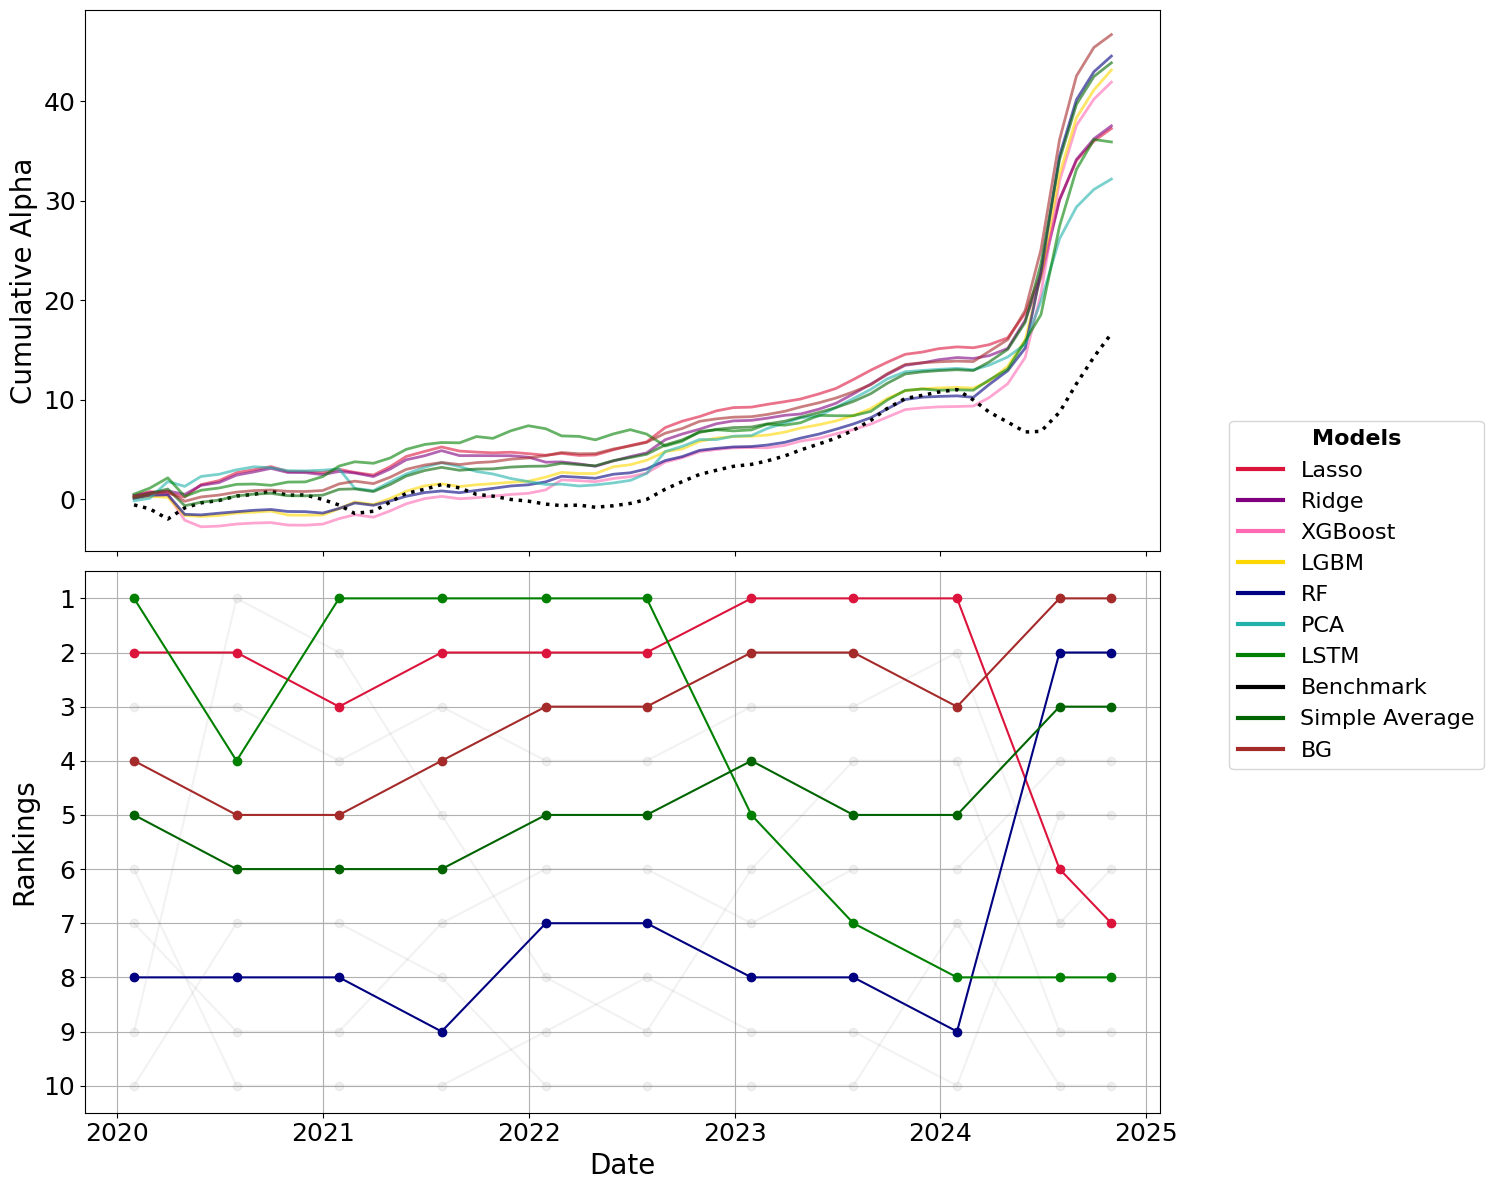

In [ ]:
color_list_healthcare = {'Ridge': 'grey', 'XGBoost': 'grey', 'PCA': 'grey', 'RF': 'navy', 'Lasso': 'crimson', 
              'LGBM': 'grey', 'LSTM': 'green', 'Benchmark': 'grey', 'Simple Average': 'darkgreen', 'BG': 'brown'}
plot_combined(all_results_healthcare_clean, plot_difference, outcome_var='rolling_alpha_5f', color_list_sector=color_list_healthcare)
color_list_tech = {'Ridge': 'grey', 'XGBoost': 'hotpink', 'PCA': 'grey', 'RF': 'navy', 'Lasso': 'crimson', 
              'LGBM': 'gold', 'LSTM': 'grey', 'Benchmark': 'grey', 'Simple Average': 'grey', 'BG': 'brown'}
plot_combined(all_results_tech_clean, plot_difference, outcome_var='rolling_alpha_5f', color_list_sector=color_list_tech) # dashed - market rate; sample XGBoost

# Plotting Healthcare and Tech Together

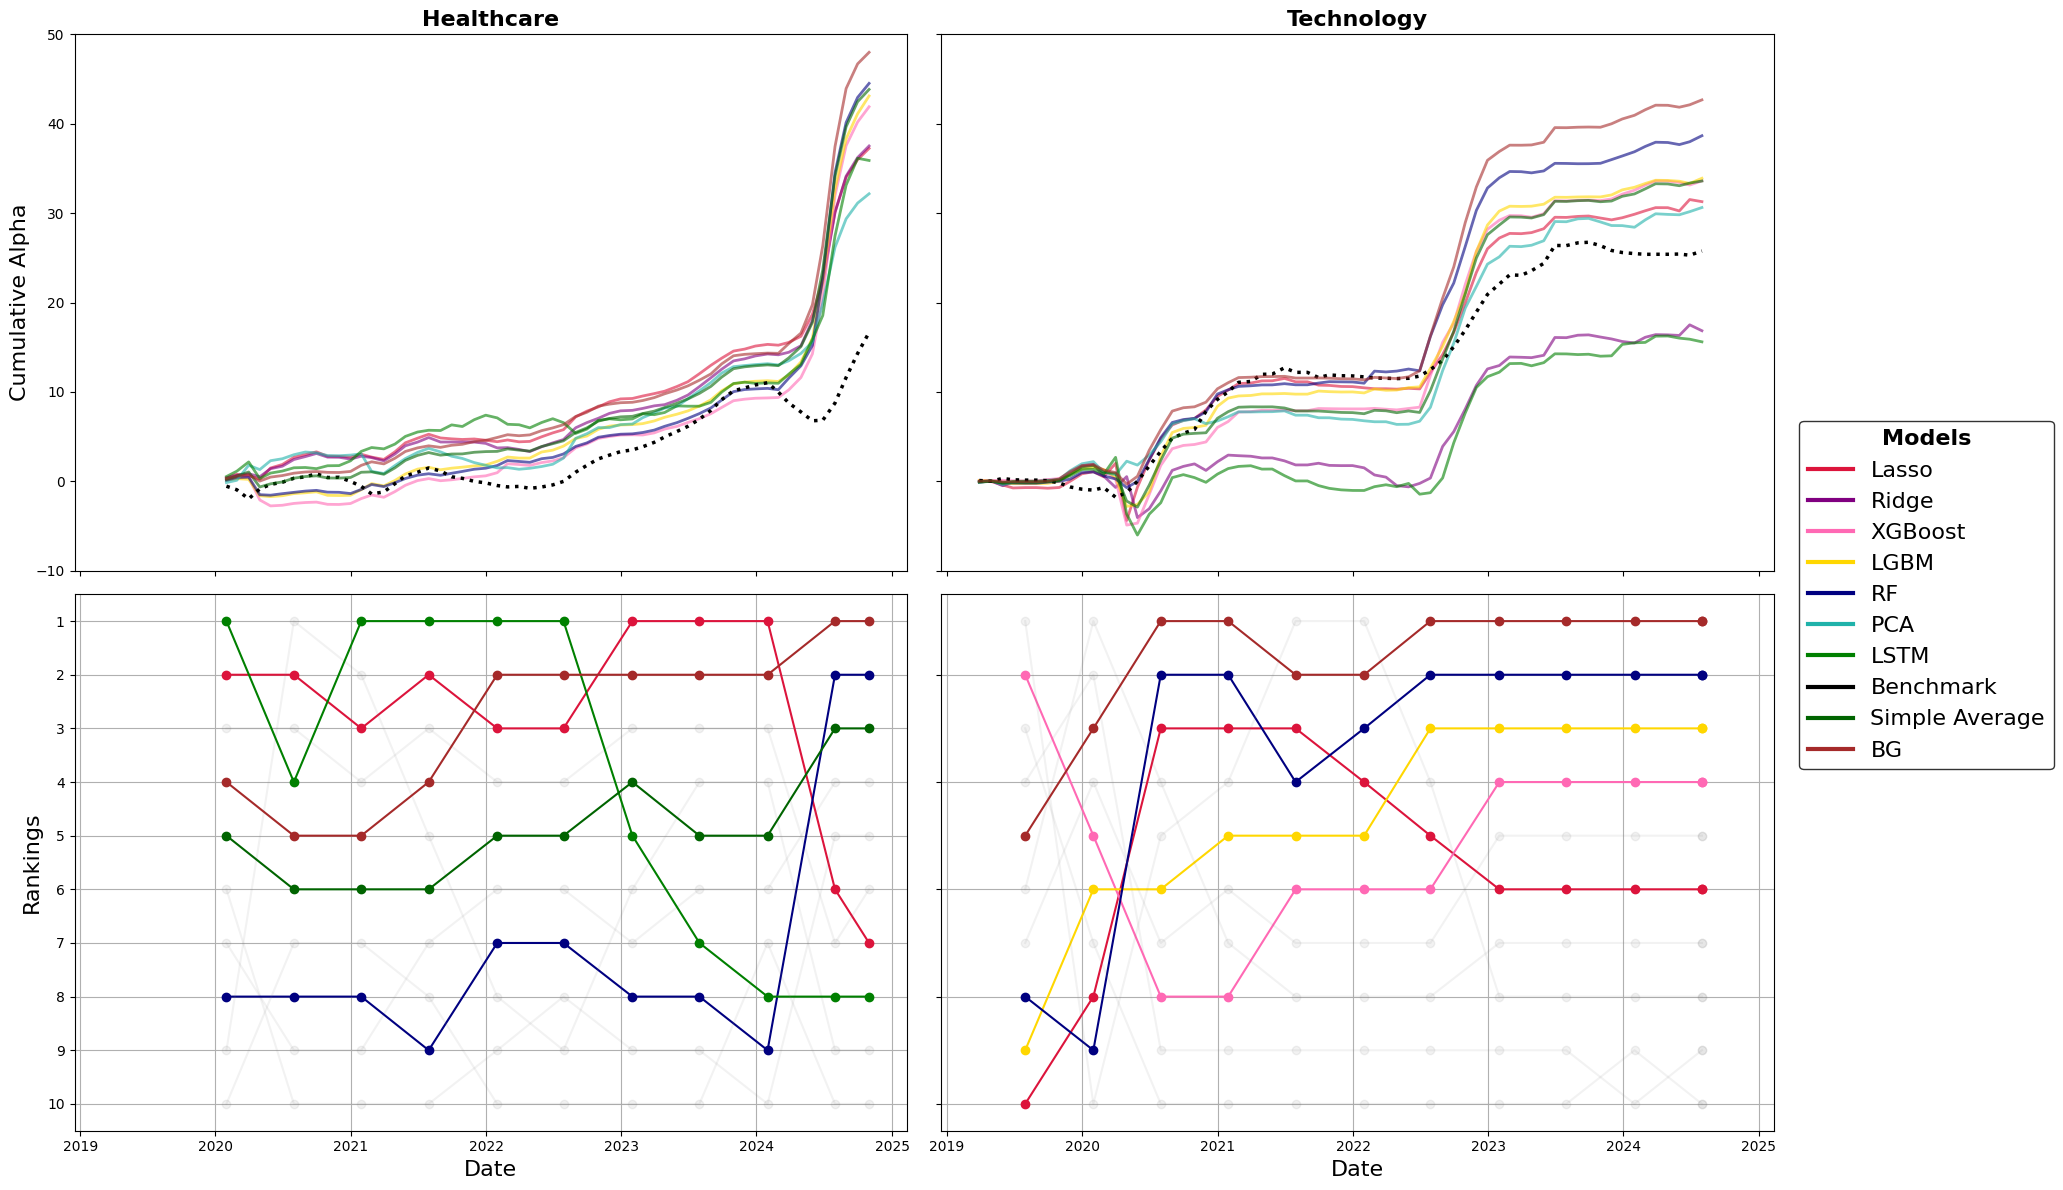

In [75]:
def plot_combined_subplot(df1, df2, plot_difference_fn, outcome_var, color_list1, color_list2):
    label_mapping = {'ridge': 'Ridge', 'xgboost': 'XGBoost', 'rf': 'RF', 'pca': 'PCA', 'lasso': 'Lasso', 
                     'lgbm':'LGBM', 'lstm':'LSTM','benchmark_alpha':'Benchmark',
                     'simple_avg':'Simple Average', 'err_weighted':'BG'}
    
    color_list = {'Ridge': 'purple', 'XGBoost': 'hotpink', 'PCA': 'lightseagreen', 'RF': 'navy', 'Lasso':'crimson', 
                  'LGBM':'gold', 'LSTM':'green', 'Benchmark':'black',
                  'Simple Average':'darkgreen', 'BG':'brown'}
    
    ranking_df1 = plot_difference_fn(df1, outcome_var=outcome_var)
    ranking_df2 = plot_difference_fn(df2, outcome_var=outcome_var)

    # Create a 2x2 subplot layout
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12), sharex=True)

    # First dataset (Healthcare) - Cumulative Alpha
    axis1 = axes[0, 0]
    axis2 = axes[1, 0]
    custom_legend_handles = []

    df1.index = pd.to_datetime(df1.index)
    df1 = df1.sort_index().groupby(df1.index).mean()
    model_cols = [col for col in df1.columns if col != outcome_var]
    df1[outcome_var] = (df1[outcome_var] - df1[outcome_var].mean()) / df1[outcome_var].std()

    for col in model_cols:
        df1[col] = (df1[col] - df1[col].mean()) / df1[col].std()
        df1[f'cumulative_action_based_{col}'] = (df1[col] * df1[outcome_var]).cumsum()
        label = label_mapping.get(col, col)
        color = color_list.get(label, 'black')
        
        if col == "benchmark_alpha":
            axis1.plot(df1.index, df1[f'cumulative_action_based_{col}'], label=label, color=color, linewidth=2.5, linestyle='dotted')
        else:
            axis1.plot(df1.index, df1[f'cumulative_action_based_{col}'], label=label, color=color, linewidth=2, alpha=0.6)

        if col not in [lbl for _, lbl in custom_legend_handles]:
            custom_legend_handles.append((plt.Line2D([0], [0], color=color, lw=3), label_mapping[col]))

    axis1.set_ylabel('Cumulative Alpha', fontsize=16)
    axis1.grid(False)
    axis1.set_ylim(-10, 50)
    for column in ranking_df1.columns:
        color = color_list1.get(label_mapping[column], 'black')
        alpha = 0.1 if color == "grey" else 1
        axis2.plot(ranking_df1.index, ranking_df1[column], label=label_mapping[column], marker='o', color=color, alpha=alpha)

    axis1.set_title("Healthcare", fontweight='bold',fontsize = 16)
    
    axis2.set_ylim(0.5, 10.5)
    axis2.set_xlabel('Date', fontsize=16)
    axis2.set_ylabel('Rankings', fontsize=16)
    axis2.invert_yaxis()
    axis2.set_yticks(range(1, 11))
    axis2.set_yticklabels([str(i) for i in range(1, 11)])
    axis2.grid(True)

    # Second dataset (Tech) - Cumulative Alpha
    axis3 = axes[0, 1]
    axis4 = axes[1, 1]

    df2.index = pd.to_datetime(df2.index)
    df2 = df2.sort_index().groupby(df2.index).mean()
    df2[outcome_var] = (df2[outcome_var] - df2[outcome_var].mean()) / df2[outcome_var].std()

    for col in model_cols:
        df2[col] = (df2[col] - df2[col].mean()) / df2[col].std()
        df2[f'cumulative_action_based_{col}'] = (df2[col] * df2[outcome_var]).cumsum()
        label = label_mapping.get(col, col)
        color = color_list.get(label, 'black')

        if col == "benchmark_alpha":
            axis3.plot(df2.index, df2[f'cumulative_action_based_{col}'], label=label, color=color, linewidth=2.5, linestyle='dotted')
        else:
            axis3.plot(df2.index, df2[f'cumulative_action_based_{col}'], label=label, color=color, linewidth=2, alpha=0.6)
    axis3.set_ylim(-10, 50)
    axis3.set_yticklabels([])
    axis3.set_title("Technology", fontweight='bold',fontsize = 16)
    # axis3.set_ylabel('Cumulative Alpha', fontsize=16)
    axis3.grid(False)

    for column in ranking_df2.columns:
        color = color_list2.get(label_mapping[column], 'black')
        alpha = 0.1 if color == "grey" else 1
        axis4.plot(ranking_df2.index, ranking_df2[column], label=label_mapping[column], marker='o', color=color, alpha=alpha)

    axis4.set_ylim(0.5, 10.5)
    axis4.set_xlabel('Date', fontsize=16)
    # axis4.set_ylabel('Rankings', fontsize=16)
    axis4.invert_yaxis()
    # axis4.set_yticks(range(1, 11))
    # axis4.set_yticklabels([str(i) for i in range(1, 11)])
    axis4.grid(True)
    axis4.set_yticklabels([])
    # Common legend
    legend = fig.legend(fontsize=16, loc='center right', bbox_to_anchor=(1.15, 0.5),
                        handles=[handle[0] for handle in custom_legend_handles],
                        labels=[handle[1] for handle in custom_legend_handles],
                        title="Models", title_fontsize=16)
    legend.get_title().set_fontweight('bold')
    legend.get_frame().set_edgecolor('black')

    plt.tight_layout()
    plt.show()

# Define color lists
color_list_healthcare = {'Ridge': 'grey', 'XGBoost': 'grey', 'PCA': 'grey', 'RF': 'navy', 'Lasso': 'crimson', 
                         'LGBM': 'grey', 'LSTM': 'green', 'Benchmark': 'grey', 'Simple Average': 'darkgreen', 'BG': 'brown'}
color_list_tech = {'Ridge': 'grey', 'XGBoost': 'hotpink', 'PCA': 'grey', 'RF': 'navy', 'Lasso': 'crimson', 
                   'LGBM': 'gold', 'LSTM': 'grey', 'Benchmark': 'grey', 'Simple Average': 'grey', 'BG': 'brown'}

# Call function for both sectors
plot_combined_subplot(all_results_healthcare_clean, all_results_tech_clean, plot_difference, 
                      outcome_var='rolling_alpha_5f', color_list1=color_list_healthcare, color_list2=color_list_tech)